# Get the vibe - Experimental Notebook

## Set up

### Imports

In [1]:
# General libraries
import numpy as np
import pandas as pd

# Image related
import matplotlib.pyplot as plt 
from matplotlib import image
from keras.preprocessing.image import load_img, img_to_array
import os

# CNN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

# Confusion Matrix & Additional Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#### Set up

In [2]:
# Import Data 
image_df = pd.read_csv("../getthevibe_api/data/fer2013.csv")

In [3]:
# Data Path
# folder_path = "../../JaildoR/getthevibe_api/getthevibe_api/data/fer2013.csv"

In [4]:
# Define Emotions
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  # indices 0 to 6

In [5]:
# Insert column emotions
image_df["emotion_new"] = image_df["emotion"].map({0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"})

In [6]:
# Define formate
FER2013_WIDTH = 48
FER2013_HEIGHT = 48

## Preprosessing

### Training Data Split

In [7]:
train_set = image_df[(image_df.Usage == 'Training')] 
val_set = image_df[(image_df.Usage == 'PublicTest')]
test_set = image_df[(image_df.Usage == 'PrivateTest')] 

### Reshape X

In [8]:
# define x
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

### Scaling 

In [9]:
X_train = (X_train/255) -0.5
X_val = (X_val/255) - 0.5
X_test = (X_test/255) - 0.5

### One hot encode y

In [10]:
# define y
y_train = train_set["emotion"]
y_val = val_set["emotion"]
y_test = test_set["emotion"]

In [11]:
y_test

32298    0
32299    5
32300    6
32301    4
32302    2
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 3589, dtype: int64

In [12]:
# One Hot Encode our Target for TensorFlow processing
from tensorflow.keras.utils import to_categorical

y_cat_train = to_categorical(y_train, num_classes=7)
y_cat_test = to_categorical(y_test, num_classes=7)
y_cat_val = to_categorical(y_val, num_classes=7)

## General Evaluation Functions

In [25]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_title('Accurary')
    ax2.legend()
    return (ax1, ax2)

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
"""
Displays a confusion matrix 
"""

def confusio(X_test, y_test, model):
    
    predicted_probabilities = model.predict(X_test)
    def prediction_from_probabilities(predicted_probabilities):
        return np.argmax(predicted_probabilities)
    y_pred = np.apply_along_axis(prediction_from_probabilities, 
                                 1,                            
                                 predicted_probabilities)
    
    
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    cm = confusion_matrix(y_test, y_pred)
    cm = cm / cm.astype(np.float).sum(axis=1) # convert into percentages
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = labels);
    fig, ax = plt.subplots(figsize=(10,10));
    title='Confusion matrix'
    plt.title(title)
    disp.plot(cmap = "PuRd", ax = ax);
    pass

##  Model

### Jaildo Model

#### Jaildo Model

In [16]:
### 1. Architecture
model = models.Sequential()

model.add(layers.Conv2D(32, (5, 5), 
                 padding='same',
                 strides = (1,1),
                 input_shape=(48, 48, 1), 
                 activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [18]:
#### 2. Compilation
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
#### 3. Fit
es = EarlyStopping(patience=5)

history = model.fit(X_train, y_cat_train,
                    epochs=50,
                    batch_size=32, 
                    verbose=1,
                    use_multiprocessing = True,
                    validation_data=(X_val,y_cat_val),
                    callbacks=[es]) 

Epoch 1/50
898/898 [==============================] - 62s 70ms/step - loss: 1.3933 - accuracy: 0.4656 - val_loss: 1.3659 - val_accuracy: 0.4770
Epoch 2/50
898/898 [==============================] - 56s 62ms/step - loss: 1.2997 - accuracy: 0.5027 - val_loss: 1.3070 - val_accuracy: 0.5068
Epoch 3/50
898/898 [==============================] - 55s 61ms/step - loss: 1.2394 - accuracy: 0.5277 - val_loss: 1.2636 - val_accuracy: 0.5205
Epoch 4/50
898/898 [==============================] - 48s 54ms/step - loss: 1.1919 - accuracy: 0.5463 - val_loss: 1.2682 - val_accuracy: 0.5208
Epoch 5/50
898/898 [==============================] - 45s 50ms/step - loss: 1.1520 - accuracy: 0.5661 - val_loss: 1.2406 - val_accuracy: 0.5344
Epoch 6/50
898/898 [==============================] - 53s 59ms/step - loss: 1.1168 - accuracy: 0.5778 - val_loss: 1.2303 - val_accuracy: 0.5375
Epoch 7/50
898/898 [==============================] - 55s 61ms/step - loss: 1.0852 - accuracy: 0.5919 - val_loss: 1.2248 - val_accuracy:

#### Jaildo Model Evaluation

In [22]:
np.array(history.history["val_accuracy"])

array([0.47701308, 0.5068264 , 0.52047926, 0.52075785, 0.53441072,
       0.53747565, 0.54249096, 0.53942603, 0.53803289, 0.54416269,
       0.53524661, 0.54081917, 0.54527724])

In [23]:
# Evaluate model on the test data
print(model.evaluate(X_test, y_cat_test, verbose=0))

[1.2863647937774658, 0.5502925515174866]


(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accurary'}>)

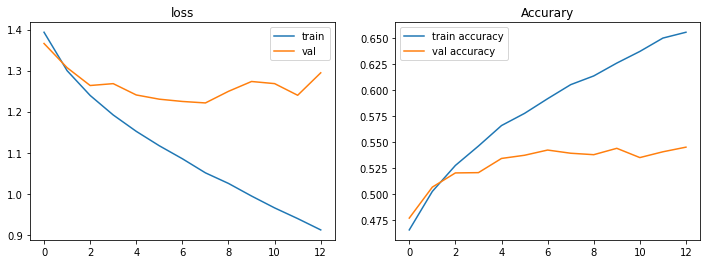

In [27]:
plot_history(history)

In [30]:
from sklearn.metrics import classification_report

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_probabilities = model.predict(X_test)
def prediction_from_probabilities(predicted_probabilities):
    return np.argmax(predicted_probabilities)
y_pred = np.apply_along_axis(prediction_from_probabilities, 
                             1,                            
                             predicted_probabilities)

print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Angry       0.45      0.45      0.45       491
     Disgust       0.40      0.33      0.36        55
        Fear       0.44      0.19      0.27       528
       Happy       0.73      0.81      0.76       879
         Sad       0.39      0.43      0.41       594
    Surprise       0.74      0.66      0.70       416
     Neutral       0.48      0.64      0.55       626

    accuracy                           0.55      3589
   macro avg       0.52      0.50      0.50      3589
weighted avg       0.54      0.55      0.54      3589



/var/folders/jk/sqv2vrvx1819g_xv6zn3w3vw0000gn/T/ipykernel_1147/29535106.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1) # convert into percentages


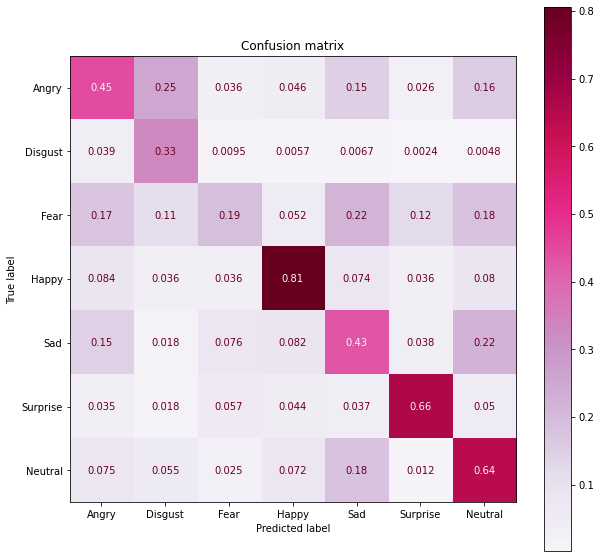

In [31]:
confusio(X_test, y_test, model)

### Insanely performing model

#### Insanely performing model

In [34]:
### 1. Architecture
model_insane = models.Sequential()

model_insane.add(layers.Conv2D(16, (5, 5), 
                 padding='same',
                 strides = (1,1),
                 input_shape=(48, 48, 1), 
                 activation='relu'))

model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_insane.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_insane.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_insane.add(layers.Flatten())
model_insane.add(layers.Dense(50, activation='relu'))
model_insane.add(layers.Dense(7, activation='softmax'))

In [35]:
#### 2. Compilation
model_insane.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
#### 3. Fit
es = EarlyStopping(patience=5)

history = model_insane.fit(X_train, y_cat_train,
                    epochs=50,
                    batch_size=32, 
                    verbose=1,
                    use_multiprocessing = True,
                    validation_data=(X_val,y_cat_val),
                    callbacks=[es]) 

Epoch 1/50
898/898 [==============================] - 41s 45ms/step - loss: 1.5982 - accuracy: 0.3771 - val_loss: 1.4285 - val_accuracy: 0.4508
Epoch 2/50
898/898 [==============================] - 38s 42ms/step - loss: 1.3801 - accuracy: 0.4725 - val_loss: 1.3475 - val_accuracy: 0.4845
Epoch 3/50
898/898 [==============================] - 39s 44ms/step - loss: 1.2700 - accuracy: 0.5163 - val_loss: 1.2885 - val_accuracy: 0.5052
Epoch 4/50
898/898 [==============================] - 39s 43ms/step - loss: 1.1992 - accuracy: 0.5441 - val_loss: 1.2420 - val_accuracy: 0.5283
Epoch 5/50
898/898 [==============================] - 39s 44ms/step - loss: 1.1373 - accuracy: 0.5718 - val_loss: 1.2248 - val_accuracy: 0.5305
Epoch 6/50
898/898 [==============================] - 38s 42ms/step - loss: 1.0859 - accuracy: 0.5882 - val_loss: 1.2285 - val_accuracy: 0.5308
Epoch 7/50
898/898 [==============================] - 36s 40ms/step - loss: 1.0390 - accuracy: 0.6083 - val_loss: 1.2077 - val_accuracy:

#### evaluation

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accurary'}>)

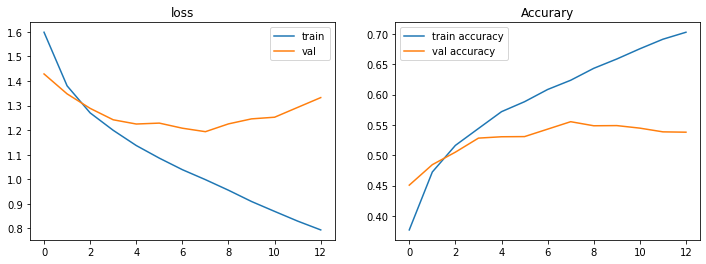

In [37]:
plot_history(history)

/var/folders/jk/sqv2vrvx1819g_xv6zn3w3vw0000gn/T/ipykernel_1147/29535106.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1) # convert into percentages


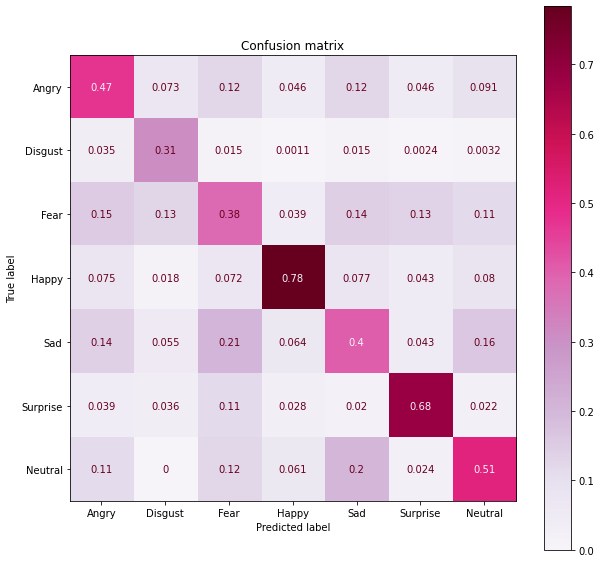

In [39]:
confusio(X_test, y_test, model_insane)